In [1]:
import pandas as pd
import numpy as np 
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,confusion_matrix,classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SVMSMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("../input/nasa-nearest-earth-objects/neo_v2.csv")

In [3]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [7]:
print(df["orbiting_body"].unique())
print(df['sentry_object'].unique())

['Earth']
[False]


Dropping columns id(high number of duplicates) ,name(too many categorical values),orbiting_body(single value),sentry_object(single_value)  and est_diamter_min(completely correalted with est_diameter_max so won't be much use)

In [9]:
df=df.drop(['id','name','orbiting_body','sentry_object','est_diameter_min'],axis=1)

In [10]:
le=LabelEncoder()
df['hazardous']=le.fit_transform(df['hazardous'])

In [11]:
df.head()

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.594347,73588.726663,6.143813e+07,20.00,1
2,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.570217,42737.733765,4.627557e+07,20.09,1


<AxesSubplot:>

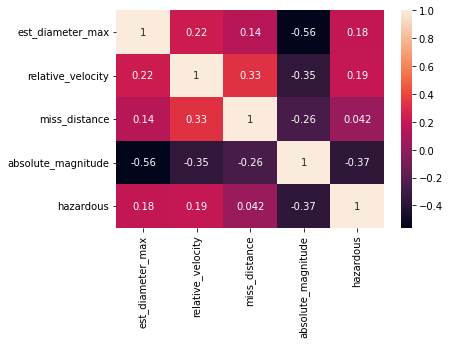

In [12]:
sns.heatmap(df.corr(), annot = True)

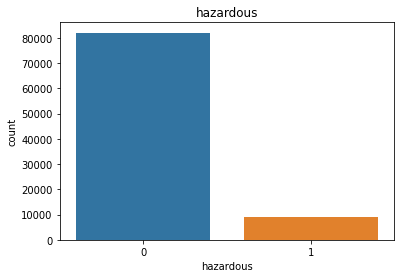

In [13]:
sns.countplot(df['hazardous'])
plt.title('hazardous')
plt.show()

<AxesSubplot:xlabel='est_diameter_max'>

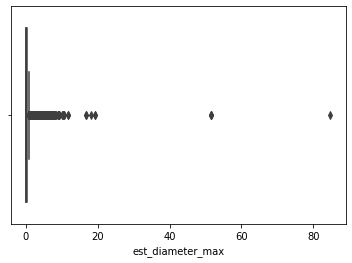

In [14]:
sns.boxplot(df['est_diameter_max'])

<AxesSubplot:xlabel='relative_velocity'>

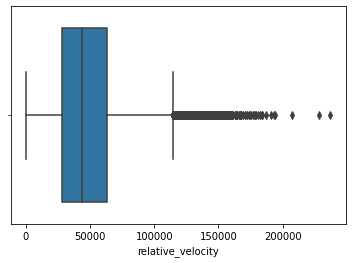

In [15]:
sns.boxplot(df['relative_velocity'])

<AxesSubplot:xlabel='miss_distance'>

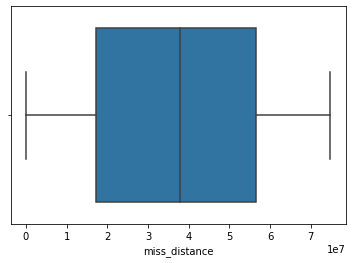

In [16]:
sns.boxplot(df['miss_distance'])

<AxesSubplot:xlabel='absolute_magnitude'>

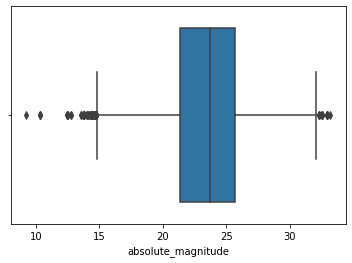

In [17]:
sns.boxplot(df['absolute_magnitude'])

Tried removing outliers but results worsened.

In [18]:
"""Q1=np.percentile(df['est_diameter_max'],25)
Q3=np.percentile(df['est_diameter_max'],75)
IQR=Q3-Q1
ul=Q3+1.5*IQR
ll=Q1-1.5*IQR
df=df[(df['est_diameter_max']<=ul) & (df['est_diameter_max']>=ll)]
df=df.reset_index(drop=True)"""

"Q1=np.percentile(df['est_diameter_max'],25)\nQ3=np.percentile(df['est_diameter_max'],75)\nIQR=Q3-Q1\nul=Q3+1.5*IQR\nll=Q1-1.5*IQR\ndf=df[(df['est_diameter_max']<=ul) & (df['est_diameter_max']>=ll)]\ndf=df.reset_index(drop=True)"

In [19]:
X=df.drop(['hazardous'],axis=1)

In [20]:
y=pd.DataFrame(df.hazardous)

As the target value is highly imbalanced tried using smote but doesn't help

In [21]:
"""sm=SVMSMOTE()
X,y=sm.fit_resample(X,y)"""

'sm=SVMSMOTE()\nX,y=sm.fit_resample(X,y)'

In [22]:
"""sns.countplot(y['hazardous'])
plt.title('hazardous')
plt.show()"""

"sns.countplot(y['hazardous'])\nplt.title('hazardous')\nplt.show()"

In [23]:
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
gc.collect()

2905

In [26]:
from sklearn.svm import SVC
model = SVC(kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [27]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Accuracy: 0.9102418259880372
Precision: 0.7694300518134715
Recall: 0.11190655614167294
F1 Score: 0.19539473684210526


<AxesSubplot:>

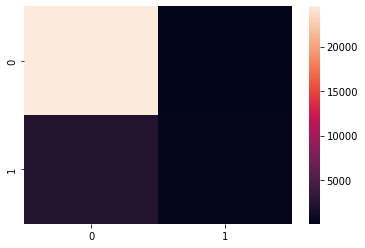

In [28]:
sns.heatmap(confusion_matrix(y_test,y_pred))

In [29]:
from sklearn.svm import LinearSVC
model = LinearSVC(tol=1e-4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Accuracy: 0.9030861252798063
Precision: 0.8095238095238095
Recall: 0.00640542577241899
F1 Score: 0.012710280373831777


<AxesSubplot:>

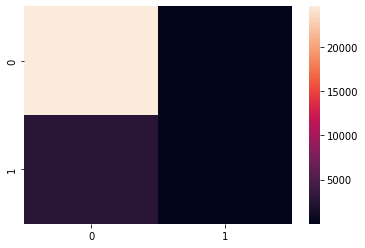

In [31]:
sns.heatmap(confusion_matrix(y_test,y_pred))

In [32]:
from sklearn.svm import SVC
model = SVC(kernel="sigmoid")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Accuracy: 0.8408131811676636
Precision: 0.17615384615384616
Recall: 0.17256970610399397
F1 Score: 0.17434335744194898


<AxesSubplot:>

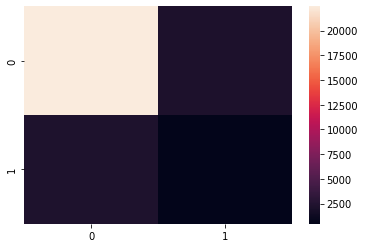

In [34]:
sns.heatmap(confusion_matrix(y_test,y_pred))

As the dataset is highly imbalanced the precision, recall and f1 score really suffer 